# クラスタリング処理ノートブック

このノートブックは、`clustering.py` の処理をJupyter Notebook形式で再構成したものです。

- 必要なライブラリのインポート
- グローバル設定
- 初期化処理
- 特徴量抽出
- クラスタリング
- 可視化
- 結果の保存

各セルを順に実行してください。

In [1]:
import os
import sys
import pickle
import re
import math
import time
import glob
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sudachipy import dictionary as sudachi_dictionary
from sudachipy import tokenizer as sudachi_tokenizer
import CaboCha
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import pykakasi
import Levenshtein
import gc

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- グローバル設定 ---
INPUT_EXCEL_PATH = '/home/ubuntu/cabochaProject/input_clustering.xlsx'
JAPANESE_WORD_LIST_PATH = '/home/ubuntu/cabochaProject/japanese_word_list2.txt'
NGRAM_DATA_BASE_PATH = '/home/ubuntu/cabochaProject/nwc2010-ngrams/word/over9'
PICKLE_CHUNK_DIR = '/home/ubuntu/cabochaProject/pickle_chunks'
OUTPUT_EXCEL_PATH = '/home/ubuntu/cabochaProject/clustering_results.xlsx'
OUTPUT_GRAPH_PATH = '/home/ubuntu/cabochaProject/clustering_visualization.png'

HF_MODEL_NAME = "rinna/japanese-gpt2-xsmall"
EDIT_DISTANCE_THRESHOLD_LOG_PROB = -10.8799
WORD_3GRAM_THRESHOLD_LOG_PROB = -8.8
WORD_3GRAM_ALPHA = 0.001
CACHE_CLEAR_INTERVAL = 100

In [3]:
# --- 初期化処理 ---
print("SudachiPy 初期化中...")
sudachi_tokenizer_dict_core = sudachi_dictionary.Dictionary(dict_type="core").create()
sudachi_dict_obj_core_for_lookup = sudachi_dictionary.Dictionary(dict_type="core")
sudachi_tokenizer_for_ngram = sudachi_dictionary.Dictionary(dict_type="core").create()
print("SudachiPy 初期化完了。")

print("CaboCha 初期化中...")
cabocha_parser = CaboCha.Parser()
print("CaboCha 初期化完了。")

print(f"Hugging Faceモデル {HF_MODEL_NAME} をロード中...")
hf_tokenizer_for_edit_dist = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
hf_model_for_edit_dist = AutoModelForCausalLM.from_pretrained(HF_MODEL_NAME)
hf_model_for_edit_dist.eval()
if torch.cuda.is_available():
    hf_model_for_edit_dist.to(torch.device("cuda"))
    print("モデルをGPUにロードしました。")
else:
    print("モデルをCPUにロードしました。")

print("pykakasi 初期化中...")
kakasi_converter_for_edit_dist = pykakasi.kakasi()
kakasi_converter_for_edit_dist.setMode("K", "E")
kakasi_converter_for_edit_dist.setMode("r", "Hepburn")
print("pykakasi 初期化完了。")

print(f"編集距離用辞書データ '{JAPANESE_WORD_LIST_PATH}' をロード中...")
all_dictionary_data_for_edit_dist = []
with open(JAPANESE_WORD_LIST_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith('#'): continue
        parts = line.split('\t')
        if len(parts) >= 2 and parts[0] and parts[1]:
            all_dictionary_data_for_edit_dist.append((parts[0], parts[1]))
print(f"{len(all_dictionary_data_for_edit_dist)} 件ロードしました。")

SudachiPy 初期化中...
SudachiPy 初期化完了。
CaboCha 初期化中...
CaboCha 初期化完了。
Hugging Faceモデル rinna/japanese-gpt2-xsmall をロード中...


/tmp/ipykernel_233441/236077770.py:3: DeprecationWarning: Parameter dict_type of Dictionary() is deprecated, use dict instead
  sudachi_tokenizer_dict_core = sudachi_dictionary.Dictionary(dict_type="core").create()
/tmp/ipykernel_233441/236077770.py:4: DeprecationWarning: Parameter dict_type of Dictionary() is deprecated, use dict instead
  sudachi_dict_obj_core_for_lookup = sudachi_dictionary.Dictionary(dict_type="core")
/tmp/ipykernel_233441/236077770.py:5: DeprecationWarning: Parameter dict_type of Dictionary() is deprecated, use dict instead
  sudachi_tokenizer_for_ngram = sudachi_dictionary.Dictionary(dict_type="core").create()
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly rea

モデルをGPUにロードしました。
pykakasi 初期化中...
pykakasi 初期化完了。
編集距離用辞書データ '/home/ubuntu/cabochaProject/japanese_word_list2.txt' をロード中...
217451 件ロードしました。


/tmp/ipykernel_233441/236077770.py:24: DeprecationWarning: Call to deprecated method setMode. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  kakasi_converter_for_edit_dist.setMode("K", "E")
/tmp/ipykernel_233441/236077770.py:25: DeprecationWarning: Call to deprecated method setMode. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  kakasi_converter_for_edit_dist.setMode("r", "Hepburn")


In [4]:
# --- 特徴量計算関数群 ---
import gc
from sudachipy import tokenizer as sudachi_tokenizer
from sudachipy import dictionary as sudachi_dictionary
import torch
import re
import sys
import Levenshtein
from tqdm import tqdm

def check_word_in_sudachi_dictionary_revised(word, dict_obj):
    morphemes = dict_obj.lookup(word)
    return len(morphemes) > 0

def calculate_dict_feature(text, tokenizer_obj, dict_obj_for_lookup_func):
    if not text or not isinstance(text, str): return 1
    try:
        mode_b = sudachi_tokenizer.Tokenizer.SplitMode.B
        morphemes = tokenizer_obj.tokenize(text, mode_b)
        found_undefined_noun = False
        noun_count = 0
        for m in morphemes:
            pos = m.part_of_speech()
            if pos and pos[0] == '名詞':
                noun_count += 1
                base_form = m.normalized_form()
                if not check_word_in_sudachi_dictionary_revised(base_form, dict_obj_for_lookup_func):
                    found_undefined_noun = True
                    break
        if noun_count == 0: return 0
        del morphemes
        gc.collect()
        return 1 if found_undefined_noun else 0
    except Exception as e:
        print(f"辞書照合エラー: {e} - テキスト: {text[:50]}...")
        return 1

def calculate_cabocha_features(text, parser):
    if not text or not isinstance(text, str): return 0.0, 0.0
    if parser is None:
        return 0.0, 0.0
    try:
        tree = parser.parse(text)
        chunks = [tree.chunk(i) for i in range(tree.chunk_size())]
        if not chunks:
            del tree
            return 0.0, 0.0
        token_to_chunk = [None] * tree.token_size()
        for ci, ch in enumerate(chunks):
            start = ch.token_pos
            size = ch.token_size
            for ti in range(start, start + size):
                if ti < len(token_to_chunk):
                    token_to_chunk[ti] = ci
        token_distances = []
        for ti in range(tree.token_size()):
            if ti >= len(token_to_chunk) or token_to_chunk[ti] is None: continue
            ci = token_to_chunk[ti]
            if ci >= len(chunks): continue
            head_ci = chunks[ci].link
            if head_ci >= 0 and head_ci < len(chunks):
                head_token_pos = chunks[head_ci].token_pos
                token_distances.append(abs(ti - head_token_pos))
        var_td = 0.0
        if token_distances:
            mean_td = sum(token_distances) / len(token_distances)
            var_td = sum((d - mean_td) ** 2 for d in token_distances) / len(token_distances)
            del mean_td
        del token_distances
        scores = [ch.score for ch in chunks if ch.score is not None]
        var_sc = 0.0
        if scores:
            mean_sc = sum(scores) / len(scores)
            var_sc = sum((s - mean_sc) ** 2 for s in scores) / len(scores)
            del mean_sc
        del scores
        del tree, chunks, token_to_chunk
        gc.collect()
        return var_td, var_sc
    except Exception as e:
        print(f"CaboCha特徴量計算エラー: {e} - テキスト: {text[:50]}...")
        return 0.0, 0.0

def is_jukugo_for_edit_dist(word):
    return bool(re.match(r'^[\u4E00-\u9FFF]{2,}$', word))

def katakana_to_romaji_for_edit_dist(katakana_text, kakasi_cv):
    if not katakana_text: return ""
    try:
        return "".join([item.get('hepburn', item.get('orig', '')) for item in kakasi_cv.convert(katakana_text)]).lower()
    except Exception: return "___romaji_error___"

def estimate_segment_reading_for_edit_dist(segment_kanji, dictionary_data):
    min_dist = sys.maxsize
    est_reading = None
    if not dictionary_data: return None
    for kanji, reading in dictionary_data:
        if not kanji: continue
        dist = Levenshtein.distance(segment_kanji, kanji)
        if dist < min_dist:
            min_dist = dist
            est_reading = reading
            if min_dist == 0: break
    return est_reading

def find_kanji_candidates_by_distance_for_edit_dist(segment_kanji, dictionary_data, max_dist=2, jukugo_only=True):
    candidates = []
    dict_to_search = dictionary_data
    if jukugo_only:
        jukugo_dict = [(k, r) for k, r in dictionary_data if is_jukugo_for_edit_dist(k)]
        if jukugo_dict: dict_to_search = jukugo_dict
    min_found_dist = sys.maxsize
    temp_candidates = []
    for kanji, reading in dict_to_search:
        if not kanji: continue
        dist = Levenshtein.distance(segment_kanji, kanji)
        if dist <= max_dist:
             temp_candidates.append({'kanji': kanji, 'reading': reading, 'dist': dist})
        if dist < min_found_dist:
            min_found_dist = dist
    if not temp_candidates and min_found_dist != sys.maxsize:
         for kanji, reading in dict_to_search:
            if not kanji: continue
            dist = Levenshtein.distance(segment_kanji, kanji)
            if dist == min_found_dist:
                temp_candidates.append({'kanji': kanji, 'reading': reading, 'dist': dist})
    seen_kanji = set()
    for cand_info in sorted(temp_candidates, key=lambda x: x['dist']):
        if cand_info['kanji'] not in seen_kanji:
            candidates.append((cand_info['kanji'], cand_info['reading'], cand_info['dist']))
            seen_kanji.add(cand_info['kanji'])
    del temp_candidates, seen_kanji, dict_to_search
    gc.collect()
    return candidates

def find_best_candidate_romaji_rerank_for_edit_dist(est_seg_reading_romaji, initial_candidates, kakasi_cv):
    min_romaji_dist = sys.maxsize
    best_cand_kanji, best_cand_reading, best_kanji_dist_orig = None, None, sys.maxsize
    if est_seg_reading_romaji in ["", "___romaji_error___"] or not initial_candidates:
        return None, sys.maxsize
    for kanji, reading, kanji_dist in initial_candidates:
        cand_reading_romaji = katakana_to_romaji_for_edit_dist(reading, kakasi_cv)
        if cand_reading_romaji == "___romaji_error___": continue
        romaji_dist = Levenshtein.distance(est_seg_reading_romaji, cand_reading_romaji)
        if romaji_dist < min_romaji_dist:
            min_romaji_dist = romaji_dist
            best_cand_kanji = kanji
            best_cand_reading = reading
            best_kanji_dist_orig = kanji_dist
    if best_cand_kanji is None: return None, sys.maxsize
    return best_cand_kanji, best_kanji_dist_orig

def calculate_edit_distance_feature(text, tokenizer, model, dictionary_data, kakasi_cv, threshold_log_p):
    if not text or not isinstance(text, str): return 0.0
    try:
        device = next(model.parameters()).device
        inputs = tokenizer(text, return_tensors="pt", return_offsets_mapping=True, truncation=True, max_length=512)
        input_ids = inputs["input_ids"].to(device)
        offset_mapping = inputs["offset_mapping"].squeeze().tolist()
        kanji_segments_info = []
        for match in re.finditer(r'[\u4E00-\u9FFF]{2,}', text):
            kanji_segments_info.append({'segment': match.group(0), 'start_char': match.start(), 'end_char': match.end()})
        if not kanji_segments_info:
            del inputs, input_ids, offset_mapping
            gc.collect()
            return 0.0
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits
        log_probs_full_sequence = torch.log_softmax(logits, dim=-1).squeeze(0)
        del outputs, logits
        segment_scores = []
        for seg_info in kanji_segments_info:
            segment_str = seg_info['segment']
            seg_start_char_idx = seg_info['start_char']
            hf_indices_for_segment = []
            for hf_token_idx, (tok_char_start, tok_char_end) in enumerate(offset_mapping):
                if tok_char_start >= seg_start_char_idx and tok_char_end <= seg_info['end_char']:
                    if hf_token_idx > 0 and hf_token_idx < input_ids.shape[1]:
                        hf_indices_for_segment.append(hf_token_idx)
            avg_log_prob = -float('inf')
            if hf_indices_for_segment:
                log_prob_sum = 0
                valid_tokens = 0
                for hf_idx in hf_indices_for_segment:
                    token_id = input_ids[0, hf_idx].item()
                    if hf_idx -1 < log_probs_full_sequence.shape[0]:
                        log_prob_sum += log_probs_full_sequence[hf_idx-1, token_id].item()
                        valid_tokens +=1
                avg_log_prob = log_prob_sum / valid_tokens if valid_tokens > 0 else -float('inf')
            segment_scores.append({'segment': segment_str, 'avg_log_prob': avg_log_prob})
        del inputs, input_ids, offset_mapping, log_probs_full_sequence, kanji_segments_info
        gc.collect()
        if not segment_scores: return 0.0
        min_score = float('inf')
        segment_with_min_score_str = None
        valid_scores = [s for s in segment_scores if s['avg_log_prob'] > -float('inf')]
        if not valid_scores:
            del segment_scores
            gc.collect()
            return 0.0
        segment_with_min_score = min(valid_scores, key=lambda x: x['avg_log_prob'])
        min_score = segment_with_min_score['avg_log_prob']
        segment_with_min_score_str = segment_with_min_score['segment']
        del segment_scores, valid_scores
        gc.collect()
        edit_distance_val = 0.0
        if min_score < threshold_log_p and segment_with_min_score_str:
            target_segment = segment_with_min_score_str
            est_reading = estimate_segment_reading_for_edit_dist(target_segment, dictionary_data)
            if not est_reading:
                edit_distance_val = float(len(target_segment))
            else:
                est_reading_romaji = katakana_to_romaji_for_edit_dist(est_reading, kakasi_cv)
                if est_reading_romaji == "___romaji_error___":
                    edit_distance_val = float(len(target_segment))
                else:
                    initial_candidates = find_kanji_candidates_by_distance_for_edit_dist(target_segment, dictionary_data)
                    if not initial_candidates:
                        edit_distance_val = float(len(target_segment))
                    else:
                        best_cand_kanji, _ = find_best_candidate_romaji_rerank_for_edit_dist(est_reading_romaji, initial_candidates, kakasi_cv)
                        if best_cand_kanji:
                            edit_distance_val = float(Levenshtein.distance(target_segment, best_cand_kanji))
                        else:
                            edit_distance_val = float(len(target_segment))
                        del initial_candidates
            del est_reading
        gc.collect()
        return edit_distance_val
    except Exception as e:
        print(f"編集距離計算エラー: {e} - テキスト: {text[:50]}...")
        if 'inputs' in locals(): del inputs
        if 'input_ids' in locals(): del input_ids
        if 'offset_mapping' in locals(): del offset_mapping
        if 'outputs' in locals(): del outputs
        if 'logits' in locals(): del log_probs_full_sequence
        if 'segment_scores' in locals(): del segment_scores
        if 'valid_scores' in locals(): del valid_scores
        gc.collect()
        return 0.0

def collect_ngram_counts_from_pickles(pickle_paths, texts, n=2):
    global sudachi_tokenizer_for_ngram
    if sudachi_tokenizer_for_ngram is None:
        sudachi_tokenizer_for_ngram = sudachi_dictionary.Dictionary(dict_type="core").create()
    mode = sudachi_tokenizer.Tokenizer.SplitMode.C
    ngram_set = set()
    for text in texts:
        try:
            morphemes = [m.surface() for m in sudachi_tokenizer_for_ngram.tokenize(text, mode)]
            for i in range(len(morphemes) - n + 1):
                ngram = tuple(morphemes[i:i+n])
                ngram_set.add(ngram)
        except Exception as e:
            print(f"形態素解析エラー: {e} - テキスト: {text[:30]}...")
            continue
    print(f"全テキストから抽出されたユニーク{n}-gram数: {len(ngram_set)}")
    ngram_count_dict = dict()
    for pkl_path in tqdm(pickle_paths, desc=f"{n}-gramピックル逐次処理"):
        try:
            with open(pkl_path, 'rb') as f:
                chunk = pickle.load(f)
                counts = chunk.get('counts', {})
                for ngram in ngram_set:
                    if ngram in counts:
                        ngram_count_dict[ngram] = counts[ngram]
            del chunk, counts
            gc.collect()
        except Exception as e:
            print(f"ピックルファイル読み込みエラー: {e} - {pkl_path}")
            continue
    print(f"集計された{n}-gram数: {len(ngram_count_dict)}")
    return ngram_count_dict

In [5]:
# --- 特徴量抽出 ---
print(f"入力ファイル '{INPUT_EXCEL_PATH}' を読み込み中...")
df_input = pd.read_excel(INPUT_EXCEL_PATH, header=None, usecols=[0])
texts_to_cluster = df_input.iloc[:, 0].astype(str).tolist()
print(f"{len(texts_to_cluster)} 件のテキストを読み込みました。")

def get_pickle_paths():
    import glob
    all_bigram_chunk_paths = sorted(glob.glob(os.path.join(PICKLE_CHUNK_DIR, "2gram_*.pkl")))
    all_trigram_chunk_paths = sorted(glob.glob(os.path.join(PICKLE_CHUNK_DIR, "3gram_*.pkl")))
    return all_bigram_chunk_paths, all_trigram_chunk_paths

all_bigram_chunk_paths, all_trigram_chunk_paths = get_pickle_paths()
trigram_counts = collect_ngram_counts_from_pickles(all_trigram_chunk_paths, texts_to_cluster, n=3)
bigram_counts = collect_ngram_counts_from_pickles(all_bigram_chunk_paths, texts_to_cluster, n=2)

gc.collect()

all_features = []
feature_names = ["熟語編集距離", "単語3-gram異常度", "Token依存距離分散", "係り受けスコア分散", "辞書照合"]
total_vocab_size_ngram = 0
if trigram_counts:
    all_words = set()
    for ngram in trigram_counts.keys():
        all_words.update(ngram)
    for ngram in bigram_counts.keys():
        all_words.update(ngram)
    total_vocab_size_ngram = len(all_words)
else:
    total_vocab_size_ngram = 0

for text_idx, text_content in tqdm(enumerate(texts_to_cluster), total=len(texts_to_cluster), desc="特徴量抽出中"):
    if text_idx > 0 and text_idx % CACHE_CLEAR_INTERVAL == 0:
        print(f"\n{text_idx}件処理後、キャッシュをクリアします。")
        gc.collect()
    f_edit_dist = calculate_edit_distance_feature(
        text_content, hf_tokenizer_for_edit_dist, hf_model_for_edit_dist,
        all_dictionary_data_for_edit_dist, kakasi_converter_for_edit_dist,
        EDIT_DISTANCE_THRESHOLD_LOG_PROB
    )
    try:
        morphemes = [m.surface() for m in sudachi_tokenizer_for_ngram.tokenize(text_content, sudachi_tokenizer.Tokenizer.SplitMode.C)]
        sentence_end_punctuations = {'。', '！', '？', '．', '!'}
        all_log_probs = []
        current_segment = []
        for m in morphemes:
            if m in sentence_end_punctuations:
                if len(current_segment) >= 3:
                    for i in range(len(current_segment) - 2):
                        w1, w2, w3 = current_segment[i], current_segment[i+1], current_segment[i+2]
                        count_w1_w2_w3 = trigram_counts.get((w1, w2, w3), 0)
                        count_w1_w2 = bigram_counts.get((w1, w2), 0)
                        numerator = count_w1_w2_w3 + WORD_3GRAM_ALPHA
                        denominator = count_w1_w2 + WORD_3GRAM_ALPHA * total_vocab_size_ngram
                        log_prob = -float('inf') if denominator == 0 else np.log(numerator) - np.log(denominator)
                        all_log_probs.append(log_prob)
                current_segment = []
            else:
                current_segment.append(m)
        if len(current_segment) >= 3:
            for i in range(len(current_segment) - 2):
                w1, w2, w3 = current_segment[i], current_segment[i+1], current_segment[i+2]
                count_w1_w2_w3 = trigram_counts.get((w1, w2, w3), 0)
                count_w1_w2 = bigram_counts.get((w1, w2), 0)
                numerator = count_w1_w2_w3 + WORD_3GRAM_ALPHA
                denominator = count_w1_w2 + WORD_3GRAM_ALPHA * total_vocab_size_ngram
                log_prob = -float('inf') if denominator == 0 else np.log(numerator) - np.log(denominator)
                all_log_probs.append(log_prob)
        is_unnatural = any(prob < WORD_3GRAM_THRESHOLD_LOG_PROB for prob in all_log_probs if prob != -float('inf'))
        f_3gram = 3 if is_unnatural else 0
        del morphemes, current_segment, all_log_probs
        gc.collect()
    except Exception as e:
        print(f"3-gram特徴量計算エラー: {e} - テキスト: {text_content[:50]}...")
        f_3gram = 0
    f_token_dist, f_dep_score = calculate_cabocha_features(text_content, cabocha_parser)
    f_dict = calculate_dict_feature(text_content, sudachi_tokenizer_dict_core, sudachi_dict_obj_core_for_lookup)
    all_features.append([f_edit_dist, f_3gram, f_token_dist, f_dep_score, f_dict])
    del f_edit_dist, f_3gram, f_token_dist, f_dep_score, f_dict
    if text_idx % (CACHE_CLEAR_INTERVAL * 2) == 0 and text_idx > 0:
        gc.collect()
features_matrix = np.array(all_features, dtype=np.float32)
del all_features
gc.collect()
features_matrix_imputed = SimpleImputer(strategy='mean').fit_transform(features_matrix)
del features_matrix
gc.collect()
features_scaled = StandardScaler().fit_transform(features_matrix_imputed)

入力ファイル '/home/ubuntu/cabochaProject/input_clustering.xlsx' を読み込み中...
969 件のテキストを読み込みました。
全テキストから抽出されたユニーク3-gram数: 30167


3-gramピックル逐次処理: 100%|██████████| 38/38 [05:25<00:00,  8.56s/it]


集計された3-gram数: 17350
全テキストから抽出されたユニーク2-gram数: 23813


2-gramピックル逐次処理: 100%|██████████| 9/9 [00:56<00:00,  6.28s/it]


集計された2-gram数: 17383


特徴量抽出中:  10%|█         | 100/969 [03:22<16:08,  1.11s/it] 


100件処理後、キャッシュをクリアします。


特徴量抽出中:  21%|██        | 200/969 [06:52<24:55,  1.94s/it]


200件処理後、キャッシュをクリアします。


特徴量抽出中:  31%|███       | 300/969 [10:12<13:23,  1.20s/it]


300件処理後、キャッシュをクリアします。


特徴量抽出中:  41%|████▏     | 400/969 [13:31<30:20,  3.20s/it]


400件処理後、キャッシュをクリアします。


特徴量抽出中:  52%|█████▏    | 500/969 [16:41<14:15,  1.82s/it]


500件処理後、キャッシュをクリアします。


特徴量抽出中:  62%|██████▏   | 600/969 [20:16<09:41,  1.58s/it]


600件処理後、キャッシュをクリアします。


特徴量抽出中:  72%|███████▏  | 700/969 [23:27<05:18,  1.18s/it]


700件処理後、キャッシュをクリアします。


特徴量抽出中:  83%|████████▎ | 800/969 [26:11<03:35,  1.27s/it]


800件処理後、キャッシュをクリアします。


特徴量抽出中:  93%|█████████▎| 900/969 [28:46<01:16,  1.11s/it]


900件処理後、キャッシュをクリアします。


特徴量抽出中: 100%|██████████| 969/969 [30:47<00:00,  1.91s/it]


In [11]:
# --- クラスタリング ---
sse = []
k_range = range(1, min(10, len(texts_to_cluster)))
for k_val in k_range:
    kmeans_elbow = KMeans(n_clusters=k_val, random_state=42, n_init='auto')
    kmeans_elbow.fit(features_scaled)
    sse.append(kmeans_elbow.inertia_)

optimal_k_val = 5  # KneeLocator等で自動決定も可
kmeans = KMeans(n_clusters=optimal_k_val, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(features_scaled)

In [12]:
cluster_labels

array([0, 1, 0, 0, 0, 1, 1, 3, 3, 3, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 3,
       2, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 3, 1, 0, 1, 1, 0, 0, 0, 0, 2,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 3, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 2, 0, 1, 0, 3, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 2, 1, 3, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 3, 1,
       0, 0, 0, 0, 1, 2, 2, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 3, 0, 1, 3, 1, 1, 1, 1,
       2, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 2, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 2, 1, 3, 0, 1, 0, 1, 2, 2, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 0, 3, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 3, 0, 1, 1, 0, 2, 1, 3, 1,
       2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,

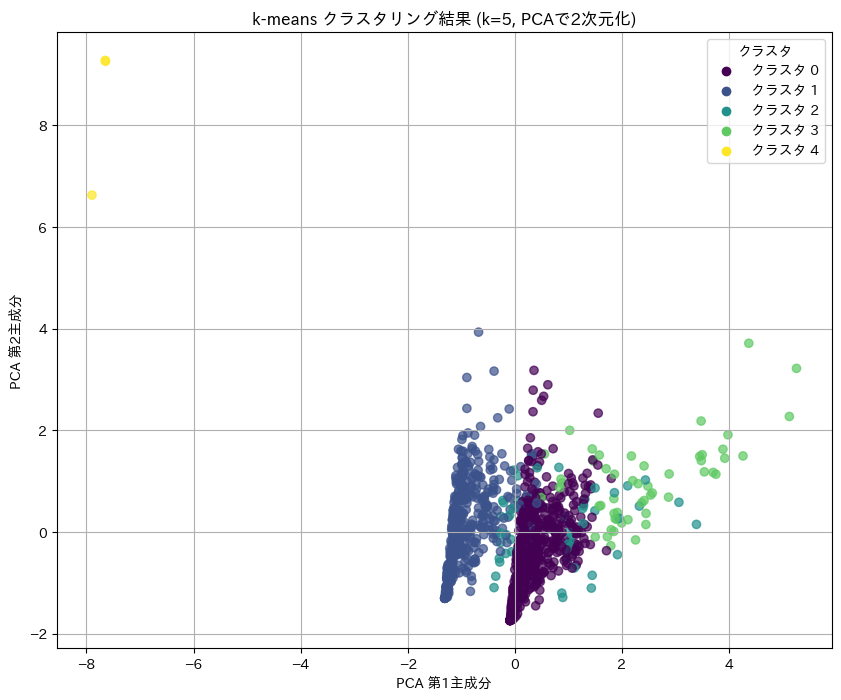

In [17]:
# --- PCAによる可視化 ---
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(features_scaled)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.legend(handles=[plt.scatter([],[], marker='o', color=scatter.cmap(scatter.norm(label)), label=f'クラスタ {label}') for label in np.unique(cluster_labels)], title="クラスタ")
plt.title(f'k-means クラスタリング結果 (k={optimal_k_val}, PCAで2次元化)')
plt.xlabel("PCA 第1主成分")
plt.ylabel("PCA 第2主成分")
plt.grid(True)
plt.savefig(OUTPUT_GRAPH_PATH)
plt.show()

In [19]:
# --- 結果の保存 ---
df_results = pd.DataFrame({'元のテキスト': texts_to_cluster})
df_features = pd.DataFrame(features_matrix_imputed, columns=["熟語編集距離", "単語3-gram異常度", "Token依存距離分散", "係り受けスコア分散", "辞書照合"])
df_results = pd.concat([df_results, df_features], axis=1)
df_results['クラスタラベル'] = cluster_labels

# クラスタラベル順で並び替え
sorted_df_results = df_results.sort_values('クラスタラベル').reset_index(drop=True)

# --- クラスタ内分散・クラスタ間分散・クラスタ別特徴量平均の計算 ---
import numpy as np
import pandas as pd

# クラスタごとの特徴量平均
cluster_feature_means = sorted_df_results.groupby('クラスタラベル').mean(numeric_only=True)
cluster_feature_means.index.name = 'クラスタラベル'

# 全体平均
overall_mean = df_features.mean().values

# クラスタ内分散（全クラスタの加重平均、特徴量ごと）
within_var = 0.0
for k, group in sorted_df_results.groupby('クラスタラベル'):
    n_k = len(group)
    if n_k > 1:
        within_var += n_k * group[df_features.columns].var(ddof=0).values
within_var = within_var / len(sorted_df_results) if len(sorted_df_results) > 0 else np.zeros(df_features.shape[1])
within_var_df = pd.DataFrame([within_var], columns=[f"クラスタ内分散_{col}" for col in df_features.columns])

# クラスタ間分散（1値のみ）
mean_vectors = cluster_feature_means.values
n_clusters = mean_vectors.shape[0]
if n_clusters > 1:
    between_var = np.mean([np.sum((mean_vec - overall_mean) ** 2) for mean_vec in mean_vectors])
else:
    between_var = 0.0
between_var_df = pd.DataFrame([[between_var]], columns=["クラスタ間分散(全特徴量ベクトル)"])

# Excel出力
with pd.ExcelWriter(OUTPUT_EXCEL_PATH, engine='openpyxl', mode='w') as writer:
    sorted_df_results.to_excel(writer, index=False, sheet_name='クラスタリング結果')
    cluster_feature_means.to_excel(writer, sheet_name='クラスタ別特徴量平均')
    within_var_df.to_excel(writer, index=False, sheet_name='クラスタ内分散')
    between_var_df.to_excel(writer, index=False, sheet_name='クラスタ間分散')
print(f"クラスタリング結果を {OUTPUT_EXCEL_PATH} に保存しました。")

クラスタリング結果を /home/ubuntu/cabochaProject/clustering_results.xlsx に保存しました。
